# 0. Setup

In [1]:
%%capture

# install required libraries
# !pip3 install google-generativeai             # Google's Gemini API (no need to install in Colab)
!pip3 install openai                            # OpenAI API
!pip3 install tiktoken                          # Estimate costs of using OpenAI models
!pip3 install ipywidgets

In [2]:
# basic libraries
import pandas as pd
import numpy as np
import os
from IPython.core.display import HTML
from tqdm import tqdm
import urllib.request
import re
import tiktoken

# LLMs APIs
import google.generativeai as genai
from openai import OpenAI

# colab secrets

from google.colab import userdata

# 1. Interacting with LLMs through APIs



### What is an API?

Application Programming Interfaces (APIs) allow applications to *speak to each other*. In our context, we will use APIs so that Python can directly speak to multiple language models. This will help us programatically interact with language models and fulfill certain tasks that can't be done manually.

<br>

*How would you summarize 10,000 different news articles using ChatGPT?*

### Requirements for using an API

To interact with an API we just need to use a programming language supported by the API (most of them support Python) and a key that identifies us. In order to get started with an API, it is always a good idea to go to the documentation provided by its creator.

- [Google](https://ai.google.dev/gemini-api)
- [OpenAI](https://platform.openai.com/docs/quickstart?context=python)
- [Anthropic](https://www.anthropic.com/api)


Below, we will provide some boilerplate code to interact with some of the main APIs in the market.

In [ ]:
#@title
display(HTML("""
<div class="alert">
  <h2> APIs Keys </h2>
  <br>
  <p> Be careful! Never leave your keys in public repositories or in files that are shared. Since some of the API services are paid, this can lead to malicious actors using your key. </p>

</div>

<style>
.alert {
  padding: 20px;
  background-color: #D72638;
  color: white;
  margin-bottom: 15px;
}

h2{
  font-size: 30px;
  color: white;
}

li, p{
  font-size: 20px;
}

</style>
"""))

### Some key parameters for text generation with LLMs

- [Temperature](https://lukesalamone.github.io/posts/what-is-temperature/): Controls the "randomness" of the generated text by influencing the underlying token probabilities.
- Max tokens: Helps you pre-define the number of tokens that the model generates.

## Google

In [ ]:
# load the key from secret manager

api_key = userdata.get("gem_key")

In [ ]:
# add your key to the API configuration
genai.configure(api_key=api_key)

In [ ]:
# Set up the model
generation_config = {
"temperature": 0.8,             # Controls the randomness of the output - temperature = 1 - use original distribution.
"max_output_tokens": 150,       # The maximum number of tokens to include - the length of the content in the result
}

In [ ]:
models = genai.list_models()

# Print out each model's name and capabilities
for model in models:
    print(f"Model name: {model.name}")
    print(f"  Description: {model.description}")
    print(f"  Supported methods: {model.supported_generation_methods}")
    print()

In [ ]:
# initialize the model
model = genai.GenerativeModel(model_name='gemini-1.5-pro',            # name of the model we want to use
                              generation_config=generation_config     # parameters
                              )

In [ ]:
# generate a response from a prompt
result = model.generate_content(contents={'role':'user',
                                          'parts': "Write a short song about the housing market in London in the style of Skepta"})

In [ ]:
# extract the text from the response object
print(result.candidates[0].content.parts[0].text)

## OpenAI

In [ ]:
# load the key from secret manager

api_key = userdata.get("openai_key")

In [ ]:
# initialize a client using the API key
client = OpenAI(api_key=api_key)

In [ ]:
# get a response from the model
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",    # name of the model,
    messages=[
        {"role": "user",
         "content": "Explain the word2vec model with some verses in the style of Samuel Taylor Coleridge."}    # prompt
    ],
    max_tokens=100,                 # max number of tokens to be generate
    temperature=0.1                 # controls the randomness of the output
)

In [ ]:
print(response.choices[0].message.content)

## Anthropic

In [ ]:
!pip3 install anthropic

from anthropic import Anthropic

client = Anthropic(
    api_key="ANTHROPIC_API_KEY",
)

message = client.messages.create(
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": "Hello, Claude",
        }
    ],
    model="claude-3-opus-20240229",
)
print(message.content)

## Cohere

In [ ]:
!pip3 install cohere

import cohere

co = cohere.Client(
    api_key="YOUR_API_KEY",
)

chat = co.chat(
    message="hello world!",
    model="command"
)

print(chat)

## Mistral AI

In [ ]:
!pip3 install mistralai

from mistralai.client import MistralClient

client = MistralClient(api_key="YOUR_KEY")

response = client.completion(
    model="codestral-latest",
    prompt="Hi",
)

response.choices[0].message.content

# 2. Demonstrating different tasks with LLMs

In order to get ourselves familiarized with how to effectively work with the API of modern LLMs, we will demonstrate two different tasks through the notebook.

- **Task 1: Structuring unstructured data.** We will use a corpus of news articles from Colombia to extract from them some of the main actors involved in the events described.
- **Task 2: Latent concept detection.** We will categorize sentences from press conferences after the Federal Open Market Committee (FOMC) as hawkish, neutral or dovish. We will compare the results obtained with an LLM with the labels provided by the authors of [The Voice of Monetary Policy](https://www.aeaweb.org/articles?id=10.1257/aer.20220129) and with a dictionary-based approach.

### Creating an effective prompt

There are many resources available online to get you started on how to build good prompts. I recommend you to search directly within the documentation of the builder of the LLM you want to use for the best advice on how to create prompts for that specific model. Here are some examples:

- OpenAI:
    - [Guide 1](https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-the-openai-api)
    - [Guide 2](https://platform.openai.com/docs/guides/prompt-engineering)
    - [Cookbook](https://cookbook.openai.com/)
- Anthropic
    - [Guide](https://docs.anthropic.com/en/docs/prompt-engineering)
    - [Cookbook](https://github.com/anthropics/anthropic-cookbook/)

- Google
    - [Guide](https://ai.google.dev/gemini-api/docs/prompting-intro)


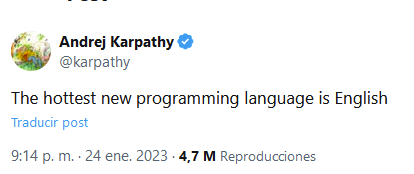

### Some principles for creating effective prompts

1. Be clear and detailed
2. Explicitly ask for an output format
3. Give the model a "role"/"persona"

## Task 1: Structuring unstructured data

Can we extract the most relevant characters discussed in a news article using an LLM?

In [ ]:
# https://www.newyorker.com/news/the-lede/donald-trump-wins-a-second-term

# load the data with utf-8 encoding

with open('./example_text.txt', 'r', encoding="utf-8") as file:
    ny_article = file.read()

In [ ]:
# print part of text

print(ny_article[:1000])

In [ ]:
# PRINCIPLE 1: Be clear and detailed (BAD PROMPT)
my_prompt = f"""
whom does this article talk about?:

{ny_article}
"""

print(my_prompt[:1000])

In [ ]:
# re-start the client
client = OpenAI(api_key=api_key)

In [ ]:
# get a response from the model
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",    # name of the model,
    messages=[
        {"role": "user",
         "content": my_prompt},
    ],
    max_tokens=100,                 # max number of tokens to generate
    temperature=0.0
)

In [ ]:
# extract response
print(response.choices[0].message.content)

In [ ]:
# PRINCIPLE 1: Be clear and detailed (GOOD PROMPT)
my_prompt = f"""
We want to extract the relevant people from a news article.

Please follow these steps:
1. Identify all the people mentioned and any description of them
2. Identify any political offices mentioned

Here is the text of the article:
{ny_article}

"""

In [ ]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",    # name of the model,
    messages=[
        {"role": "user", "content": my_prompt},
    ],
    max_tokens=1000,                 # max number of tokens to be generate
    temperature=0.0                 # temperature
)

In [ ]:
print(response.choices[0].message.content)

In [ ]:
# PRINCIPLE 2: Explicitly ask for an output format

my_prompt = f"""
We want to extract the relevant characters from a news article. Provide your output in json format with each step as a key.

Please follow these steps:
1. People: Identify all the people mentioned and any description of them
2. Institutions: Identify all the institutions mentioned

Here is the text of the article:
{ny_article}

"""

In [ ]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",    # name of the model,
    messages=[
        {"role": "user", "content": my_prompt},
    ],
    max_tokens=1000,                 # max number of tokens to be generate
    temperature=0.0                 # temperature
)

In [ ]:
print(response.choices[0].message.content)

In [ ]:
# https://www.texastribune.org/2024/09/18/texas-venezuelan-gang-tren-de-aragua-abbott-crackdown/

# load the data with utf-8 encoding

with open('./example_text2.txt', 'r', encoding="utf-8") as file:
    tt_article = file.read()

In [ ]:
# PRINCIPLE 3: Give the model a role/persona
my_prompt = f"""Summarize the article below.
Article:
{tt_article}
"""

We will give the model its role/person through a **system prompt**. Anthropic provides a nice [guide](https://docs.anthropic.com/en/docs/system-prompts) explaining what system prompts are and how to use them.

In [ ]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",    # name of the model,,
    messages=[
        {"role": "system", "content": "You are a helpful assistant that replies with a concise one-sentence answer that always starts with the letter T."},  # define the ROLE/PERSONA
        {"role": "user", "content": my_prompt},
    ],
    max_tokens=100,                 # max number of tokens to be generate
    temperature=0.0                 # temperature
)

In [ ]:
print(response.choices[0].message.content)

In [ ]:
# Under-the-hood the "system prompt" is partially how the models have certain guardrails

response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",    # name of the model,
    messages=[
        {"role": "system", "content": """You are a language model that works with young children. Never produce content related to violence or gangs."
        If asked to produce this content please reply with the phrase "I can't do that :( \nViolence is not good  " """
        },
        {"role": "user", "content": my_prompt},
    ],
    max_tokens=100,                 # max number of tokens to be generate
    temperature=0.0                 # temperature
)

In [ ]:
print(response.choices[0].message.content)

## Task 2: Latent Concept Detection

To demonstrate this task we will use data from [The Voice of Monetary Policy (Gorodnichenko  et. al 2023)](https://www.aeaweb.org/articles?id=10.1257/aer.20220129) paper that contains labeled sentences from press conferences after FOMC meetings. Sentences were labeled as hawisk, neutral or dovish.

In [ ]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",    # name of the model,
    messages=[
        {"role": "system", "content": """You are an expert financial analyst with great capacity to explain complex concepts to a broad audicence."""},
        {"role": "user", "content": "Explain the meaning of hawkish and dovish"},
    ],
    max_tokens=200,                 # max number of tokens to be generate
    temperature=0.0                 # temperature
)

In [ ]:
print(response.choices[0].message.content)

In [ ]:
file_id = "1INq3wr9DuykD4iSlUCocHegOJ5qgLP8z"
df = pd.read_csv(f"https://drive.google.com/uc?export=download&id={file_id}&authuser=0&export=download", sep="\t")
df.head()

In [ ]:
# explore a sentence and its label
i = np.random.randint(0, len(df))
print("Label: ", df.loc[i, "sentiment"], "\n\n")
print(df.loc[i, "text"])

In [ ]:
# first attempt at a prompt
def generation_prompt(text):
    prompt = f"""
    Classify the following text as hawkish, dovish, or neutral.

    Text: {text}
    """
    return prompt

In [ ]:
i = 1184
print("Label: ", df.loc[i, "sentiment"])
text = df.loc[i, "text"]
my_prompt = generation_prompt(text)
print(my_prompt)

In [ ]:
# re-start the client
client = OpenAI(api_key=api_key)

In [ ]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",    # name of the model
    messages=[
        {"role": "user", "content": my_prompt},
    ],
    max_tokens=10,                  # max number of tokens to be generate
    temperature=0.0                 # temperature
)

In [ ]:
print(response.choices[0].message.content)

In [ ]:
#@title
display(HTML("""
<div class="alert">
  <h2> Exercise </h2>
  <br>
  <p> 1. Improving the prompt </p>
  <br>
  <ol type="a">
  <li> Expand the current prompt in a way that helps generate better results.</li>
  <li> What principles or ideas did you use? </li>
  <li> Try your new prompt. Any improvements? </li>
  </ol>
  <br>

</div>

<style>
.alert {
  padding: 20px;
  background-color: #586BA4;
  color: white;
  margin-bottom: 15px;
}

h2{
  font-size: 30px;
  color: white;
}

li, p{
  font-size: 20px;
}

</style>
"""))

In [ ]:
# Modify the function
def generation_prompt(text):
    prompt = f"""



    YOUR WONDERFUL NEW PROMPT





    {text}
    """
    return prompt

In [ ]:
# generate text from the model

In [ ]:
# print response

In [ ]:
#@title
display(HTML("""
<div class="alert">
  <h2> DON'T GO BEYOND THIS POINT ON YOUR OWN </h2>




</div>

<style>
.alert {
  padding: 20px;
  background-color: #F49D37;
  color: white;
  margin-bottom: 20px;
}

h2{
  font-size: 50px;
  color: white;
}

li, p{
  font-size: 20px;
}

</style>
"""))

In [ ]:
# Source of inspiration for the prompt:
# https://www.newyorkfed.org/medialibrary/media/research/conference/2023/FinTech/400pm_Hansen_Paper_Kazinnik_2023.pdf?sc_lang=en&hash=9B1647BD6876D0F3959C6919BA3F82DE

def generation_prompt(text):
    prompt = f"""
    Your task is to classify the text into one of the three categories ("dovish", "neutral", "hawkish").
    The text is taken at random from the texts of FOMC announcements.
    Provide your output in json format with a key "category" and the selected category.

    Text:
    {text}
    """
    return prompt

In [ ]:
#i = np.random.randint(0, len(df))
i = 1184
text = df.loc[i, "text"]
sentiment = df.loc[i, "sentiment"]
my_prompt = generation_prompt(text)
print("Human label for sentiment: ", sentiment)
print(my_prompt)

In [ ]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",    # name of the model
    messages=[
        {"role": "system", "content": "You are a research assistant working for the Fed. You have a degree in Economics."},
        {"role": "user", "content": my_prompt},
    ],
    max_tokens=15,                 # max number of tokens to be generate
    temperature=0                  # temperature
)

In [ ]:
print(response.choices[0].message.content)

### Estimating the cost

In [ ]:
# To get the tokeniser corresponding to a specific model in the OpenAI API:
cost_per_million_input = 0.5
cost_per_million_output = 1.5

enc = tiktoken.encoding_for_model("gpt-3.5-turbo-0125")

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def calculate_cost(input_tokens, output_tokens, input_cost, output_cost):
    return (input_tokens/1000000)*input_cost + (output_tokens/1000000)*output_cost


prompt = """You are a research assistant working for the Fed. You have a degree in Economics.
Your task is to classify the text into one of the three categories ("dovish", "neutral", "hawkish").
The text is taken at random from the texts of FOMC announcements.
Provide your output in json format with a key "category" and the selected category.
"""

In [ ]:
all_costs = []
for text in df["text"].values:
    all_text = prompt + text
    num_tokens_input = num_tokens_from_string(all_text, "gpt-3.5-turbo")
    num_tokens_output = 15
    cost = calculate_cost(num_tokens_input, num_tokens_output,
                          cost_per_million_input, cost_per_million_output)
    all_costs.append(cost)

In [ ]:
df["cost"] = all_costs
df

In [ ]:
print(f"Total cost of processing the data: {np.round(df['cost'].sum(), 3)} USD")

### Running the model on many texts

Some resources on how to run many prompts:

- [Batch processing](https://cookbook.openai.com/examples/batch_processing)
- [Rate limits](https://platform.openai.com/docs/guides/rate-limits/error-mitigation)

In [ ]:
def classify_response(result):
    if "hawkish" in result:
        return "hawkish"
    elif "dovish" in result:
        return "dovish"
    elif "neutral" in result:
        return "neutral"
    else:
        return np.nan

In [ ]:
# # DON'T RUN!
# all_responses = []
# for text in tqdm(df["text"]):
#     my_prompt = generation_prompt(text)
#     response = client.chat.completions.create(
#         model="gpt-3.5-turbo-0125",    # name of the model,
#         messages=[
#             {"role": "system", "content": "You are a research assistant working for the Fed. You have a degree in Economics."},
#             {"role": "user", "content": my_prompt},
#         ],
#         max_tokens=15,               # max number of tokens to be generate
#         temperature=0                # temperature
#     )
#     result = response.choices[0].message.content
#     all_responses.append(classify_response(result))

# # append data to existing dataframe
# df["gpt_response"] = all_responses
# df

In [ ]:
# read data after doing GPT classification
file_id = "1v6U80WISF4TxXTLPBvTpiV8iWlIgNsHG"
df = pd.read_csv(f"https://drive.google.com/uc?export=download&id={file_id}&authuser=0&export=download", sep=",")
df.head()

In [ ]:
# calculate accuracy
df["gpt_correct"] = df["sentiment"] == df["gpt_response"]
gpt_accuracy = df["gpt_correct"].mean()
print(f"Random guessing accuracy: {1/3}")
print(f"Accuracy of GPT: {gpt_accuracy}")

# 3. Getting embeddings from the API

[OpenAI Embeddings Guide](https://platform.openai.com/docs/guides/embeddings)

In [ ]:
# initialize a client using the API key
client = OpenAI(api_key=api_key)

In [ ]:
text = "This is a small test to get some embeddings."
result = client.embeddings.create(input = [text],
                                  model="text-embedding-3-small")

In [ ]:
embeddings = result.data[0].embedding
len(embeddings)